# Neural network development for turbulence modeling in URANS simulations of non-Newtonian media slope flows

URANS mathematical model:
\begin{equation}
	\label{vof}
	\left\{
		\begin{aligned}
			&\boldsymbol{\nabla} \cdot \bar{\boldsymbol{u}} = 0,\\
			&\frac{\partial \bar{\alpha}}{\partial t} + \boldsymbol{\nabla} \cdot (\bar{\boldsymbol{u}} \bar{\alpha}) = 0,\\
			&\frac{\partial (\rho \bar{\boldsymbol{u}})}{\partial t} + \boldsymbol{\nabla} \cdot (\rho \bar{\boldsymbol{u}} \bar{\boldsymbol{u}}) = -\boldsymbol{\nabla} \bar{p} + \boldsymbol{\nabla} \cdot \bar{\boldsymbol{\tau}} + \rho \bar{\boldsymbol{f}}.
		\end{aligned}
	\right.
\end{equation}
Here $\bar{\boldsymbol{u}}$ is the speed of the mixture, horizontal bar means Reynolds averaging, $\bar{\alpha}$ is the volume fraction of the selected phase, $\bar{\boldsymbol{\tau}} = \bar{\boldsymbol{\tau}}_{Re} + \bar{\boldsymbol{\tau}}_m$ is the stress tensor calculated as sum of Reynolds stress tensor and viscous stress tensor, $\bar{\boldsymbol{\tau}}_m = 2 \mu \bar{\boldsymbol{s}}$ is the viscous stress tensor, which is a function of the strain rate tensor $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$, $\mu = \nu \rho$ is dynamic viscosityof a mixture which is calculated as a product of density and kinematic viscosity of mixture, $\nu = \nu_1 \bar{\alpha} + \nu_0 (1 -\bar{\alpha})$ is the kinemsatic viscosity of mixture calculated according to the principle of the weighted average, $\nu_0$ is a constant, $\nu_1 = min (\nu_*, (\tau_* + K \dot{\gamma}^n) / \dot{\gamma})$ is Herschel-Bulkley reology ratio, $\rho = \rho_1 \bar{\alpha} + \rho_0 (1 - \bar{\alpha})$ is the mixture density, $\rho_0$ and $\rho_1$ are constants, $\bar{p}$ is the pressure, $\bar{\boldsymbol{f}}$ is the density of the body forces.

The $\bar{\boldsymbol{\tau}}_{Re}$ Reynolds stress tensor is calculetaed using Tensor Basis Neural Network (TBNN) according to the principle presented in the work of Pope [1]. It is presented as function of strain rate $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ and rotation rate $\bar{\boldsymbol{r}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} - (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$ tensors, and 10 their isotropic combinations $T^i$ and 5 invariants $\lambda_i$. Calculations performed for normalized tensors $\bar{\tau}_{Re}'$, $\bar{\boldsymbol{s}}'$, $\bar{\boldsymbol{r}}'$. The scaling parameters $U_0$, $h_0$, $\rho$ used for normalization:

\begin{equation}
	\label{norm}
	\left\{
		\begin{aligned}
			&\bar{\boldsymbol{\tau}}_{Re} = \bar{\boldsymbol{\tau}}_{Re}' \rho U_0 h_0,\\
			&\bar{\boldsymbol{s}} = \bar{\boldsymbol{s}}' U_0^2 / h_0,\\
			&\bar{\boldsymbol{r}} = \bar{\boldsymbol{r}}' U_0^2 / h_0.
		\end{aligned}
	\right.
\end{equation}

In what follows, we omit the apostrophe symbol and keep in mind that we are considering normalized tensors.

Normalized Reynolds stress tensor is

\begin{equation}
	\label{MLReynolds}
	\bar{\boldsymbol{\tau}}_{Re} = \sum\limits_{n=1}^{10} g^{(n)} (\lambda_1, ... , \lambda_5) \boldsymbol{T}^{(n)}.
\end{equation}

\begin{equation}
	\begin{aligned}
		&\boldsymbol{T}^{(1)} = \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(6)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} + \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \frac{2}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(2)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} - \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},
		&&\boldsymbol{T}^{(7)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}} \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}} \bar{\boldsymbol{r}},\\
		&\boldsymbol{T}^{(3)} = \bar{\boldsymbol{s}}^2 - \frac{1}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2),
		&&\boldsymbol{T}^{(8)} = \bar{\boldsymbol{s}} \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}} \bar{\boldsymbol{s}},\\
		&\boldsymbol{T}^{(4)} = \bar{\boldsymbol{r}}^2 - \frac{1}{3}\boldsymbol{I} \cdot Tr(\bar{\boldsymbol{r}}^2),
		&&\boldsymbol{T}^{(9)} = \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 + \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \frac{2}{3} \boldsymbol{I} \cdot Tr(\bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2),\\
		&\boldsymbol{T}^{(5)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 - \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
		&&\boldsymbol{T}^{(10)} = \bar{\boldsymbol{r}} \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}}^2 - \bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2 \bar{\boldsymbol{r}},
	\end{aligned}
\end{equation}
\begin{equation}
	\lambda_1 = Tr(\bar{\boldsymbol{s}}^2),\ \ \ \ \lambda_2 = Tr(\bar{\boldsymbol{r}}^2),\ \ \ \ \lambda_3 = Tr(\bar{\boldsymbol{s}}^3),\ \ \ \ \lambda_4 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}),\ \ \ \ \lambda_5 = Tr(\bar{\boldsymbol{r}}^2 \bar{\boldsymbol{s}}^2).
\end{equation}

Calculations performed for turbulent flow in inclined chute with the rectangular cross-section. Scheme of flow is shown in figure below.

<div>
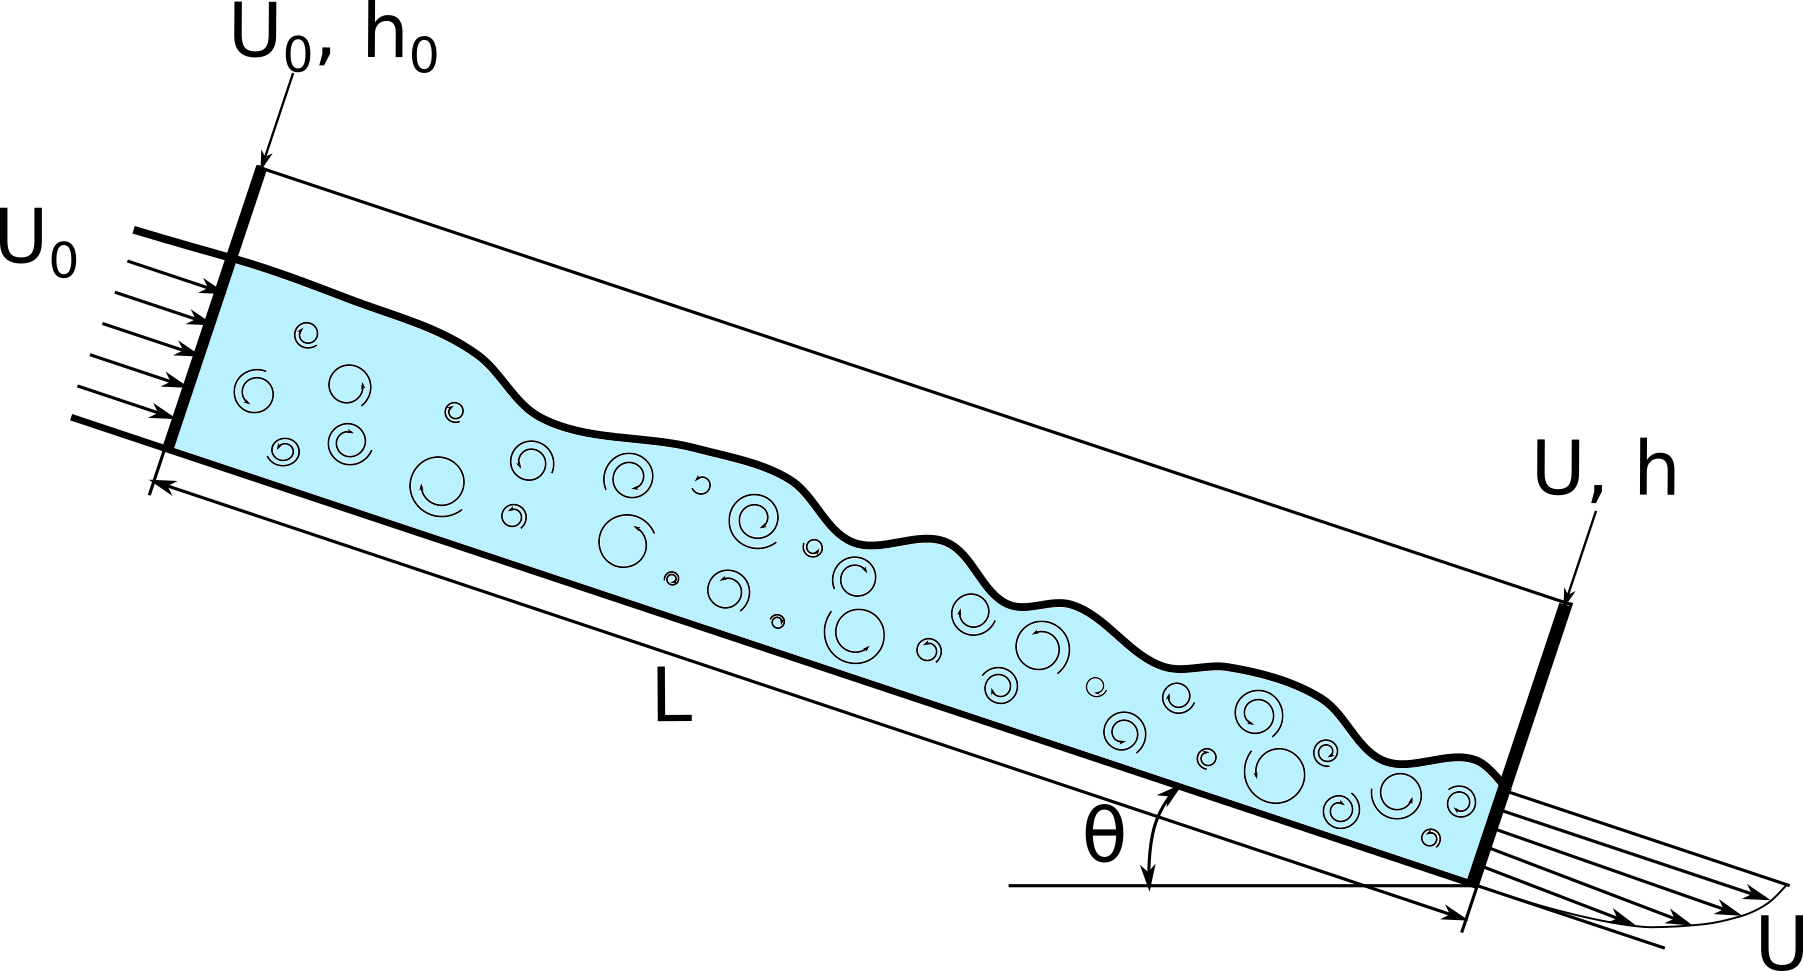
</div>

In the considered flow
\begin{equation}
    U_0 = 0.4\ \text{m}/\text{s},\ \ \ h_0 = 0.01\ \text{m},\ \ \ \theta = 25^\circ,\ \ \ L = 0.1\ \text{m}.
\end{equation}

Reynolds number of flow is 
\begin{equation}
    \text{Re} = U_0 h_0 / \nu_{eff},
\end{equation}

\begin{equation}
    \nu_{eff} = \frac{\tau_* + K (U_0/h_0)^n}{\rho (U_0 / h_0)}.
\end{equation}

Constants in calculation are set as follows:

\begin{equation}
    \nu_* = 10^7\ \text{m}^2/\text{s},\ \ \ \tau_* = 2 \cdot 10^{-3}\ \text{m}^2/\text{s}^2,\ \ \ K = 10^{-4}\ \text{m}^2/\text{s},\ \ \ n = 0.8,\ \ \ \rho = 100\ \text{kg}/\text{m}^3.
\end{equation}

So effective viscosity and Reynolds number are:

\begin{equation}
    \nu_{eff} = 10^{-6}\ \text{m}^2/\text{s},\ \ \ \text{Re} = 4000.
\end{equation}

The mesh cell linear size must be $dx = \frac{h_0}{\text{Re}^{3/4}} = 2 \cdot 10^{-5}$. Time step $dt = 5 \cdot 10^{-5}$.

Mesh size for computational domain size of 0.1x0.011x0.002 m$^3$ is $27.5 \cdot 10^7$.

[1] S. B. Pope. A more general effective-viscosity hypothesis.Journal of Fluid Mechanics,72(2):331–340, 1975.

## Current research

Above was global formulation for TBNN (Tensor Based Neural Network) with implemengtation into mathematical model. Now let's try to realize ML-turbulence model as a correction step for variables $\bar{\boldsymbol{u}}$, $\bar{\alpha}$, $\bar{p}$.

Will use tensors $\boldsymbol{T}^{(i)}$, invariants $\lambda_i$ and variables $\bar{\boldsymbol{u}}$, $\bar{p}$, $\bar{\alpha}$ as a features of NN (Neural Network). As a targets will be the differenses between DNS and RANS values for $\boldsymbol{u}$, $\alpha$ and $p$.

Let's start with importing libraries.

In [1]:
!python3 --version

Python 3.9.7


In [6]:
#!pip install git+https://github.com/tensorflow/docs
#!pip install -q -U keras-tuner
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz
#!pip install pyyaml h5py

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import keras_tuner as kt
import subprocess as sp
import fileinput as fi
from keras.utils.vis_utils import plot_model

print(tf.__version__)

2022-02-22 15:32:47.942432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-22 15:32:47.942472: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0


In [3]:
def timeStepsList():
    timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
    index = np.argsort(timeStepsList.astype(float))
    timeStepsList = timeStepsList[index]
    #return np.asarray(timeStepsList[1:-2], dtype=str)
    return timeStepsList[1:-2]

In [4]:
def readTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr

In [5]:
def readSymmTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr[[fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'8']]

In [6]:
def readSkewSymmTensor(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4',\
                   fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr[[fileName[0]+'1', fileName[0]+'2', fileName[0]+'5']]

In [7]:
def readVector(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
    arr = arr.iloc[:,0].str.split(expand=True)
    arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2']
    arr.loc[:,:] = arr.loc[:,:].astype(float)
    return arr

In [8]:
def readScalar(fileName, folder, time, sz):
    arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
    arr.columns = [fileName[0]]
    arr[:] = arr[:].astype(float)
    print(arr.info())
    return arr

In [9]:
def prepareLabels(data):
    data['dU0'] = data['res/Uref0'] - data['res/U0']
    data['dU1'] = data['res/Uref1'] - data['res/U1']
    data['dU2'] = data['res/Uref2'] - data['res/U2']
    data['dAW'] = data['res/AWref'] - data['res/alpha.water']
    data['dp'] = data['res/p_rghref'] - data['res/p_rgh']

In [10]:
def prepareInit(fullData):
    data = fullData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].copy()
    data['dU0'] = fullData['dU0']# / fullData['res/Uref0']
    data['dU1'] = fullData['dU1']# / fullData['res/Uref1']
    data['dU2'] = fullData['dU2']# / fullData['res/Uref2']
    data['dAW'] = fullData['dAW']# / fullData['res/AWref']
    data['dp'] = fullData['dp']# / fullData['res/p_rghref']
    return data

In [11]:
def preparePrediction(dataPredicted, fullData):
    data = dataPredicted.copy()
    data['dU0'] = (fullData['dU0'] - dataPredicted['dU0'])# / fullData['res/Uref0']
    data['dU1'] = (fullData['dU1'] - dataPredicted['dU1'])# / fullData['res/Uref1']
    data['dU2'] = (fullData['dU2'] - dataPredicted['dU2'])# / fullData['res/Uref2']
    data['dAW'] = (fullData['dAW'] - dataPredicted['dAW'])# / fullData['res/AWref']
    data['dp'] = (fullData['dp'] - dataPredicted['dp'])# / fullData['res/p_rghref']
    return data

In [12]:
def formDataset(TSL, TSLlen, folder, FsScalars, FsVectors, FsTensors, FsSymmTensors, FsSkewSymmTensors, size):
    data = pd.DataFrame()
    for time in TSL:
        if TSLlen == 1:
            time = TSL
        kwargs = {'folder':folder, 'time':time, 'sz':size}
        scalars = FsScalars.apply(readScalar, axis=1, **kwargs)
        vectors = FsVectors.apply(readVector, axis=1, **kwargs)
        tensors = FsTensors.apply(readTensor, axis=1, **kwargs)
        symmTensors = FsSymmTensors.apply(readSymmTensor, axis=1, **kwargs)
        skewSymmTensors = FsSkewSymmTensors.apply(readSkewSymmTensor, axis=1, **kwargs)
        tmp = pd.concat(\
                        list(scalars[:])+\
                        list(vectors[:])+\
                        list(tensors[:])+\
                        list(symmTensors[:])+\
                        list(skewSymmTensors[:]), axis=1)
        data = data.append(tmp, ignore_index=True)
        prepareLabels(data)
        if TSLlen == 1:
            break
    return data

In [13]:
def writePrediction(arr, arrType, time, folder, fileName):
    sp.run('cp '+folder+time+'/patterns/'+fileName+'PatternBeginning '+folder+time+'/'+ time+'/'+fileName, shell=True, check=True)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as f:
        f.write(str(len(arr))+'\n(\n')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('folderName', '"'+time+'"'), end='')
    with fi.FileInput(folder+time+'/'+time+'/'+fileName, inplace=True) as file:
        for line in file:
            print(line.replace('fieldName', fileName), end='')
    if arrType == 'vector':
        arr = arr.astype(str)
        arr = '( '+arr.iloc[:,0]+' '+arr.iloc[:,1]+' '+arr.iloc[:,2]+' )'
    elif arrType == 'scalar':
        arr = arr.astype(str)
    arr.to_csv(folder+time+'/'+time+'/'+fileName, mode='a', index=False, header=False)
    with open(folder+time+'/'+time+'/'+fileName, 'a') as\
        fout, fi.input(folder+time+'/'+'patterns/'+fileName+'PatternEnding') as fin:
            for line in fin:
                fout.write(line)

In [14]:
#writePrediction(testLastData[['dU0', 'dU1', 'dU2']], 'vector', testLastTSL, MLturbRANSfolder ,'dU')
#writePrediction(testLastData[['dp']], 'scalar', testLastTSL, MLturbRANSfolder ,'dp')

Below all fiatures listed. alpha.water is $\bar{\alpha}$, 'alpha.water', 'U' and 'p_rgh' are initial values. Parameters from res/ folder are calculated without turbulence model using base interFoam solver. 'Uref', 'AWref' and 'p_rghref' are reference values calculated using DNS data.

In [15]:
TSL = timeStepsList()
testTSL = TSL[[int(len(TSL)/2), -1]]
testCenterTSL = TSL[int(len(TSL)/2)]
testLastTSL = TSL[-1]
TSL = np.delete(TSL, [int(len(TSL)/2), -1])
TSL = TSL[:2]
lenTSL = len(TSL)
MLturbRANSfolder = 'TIF'
KEturbRANSfolder = 'KEIF'
KWturbRANSfolder = 'KWIF'
deltaT = 1e-06
size = 300000
FsScalars = pd.DataFrame([['alpha.water'], ['res/alpha.water'], ['res/AWref'], ['p_rgh'], ['res/p_rgh'],\
                          ['res/p_rghref'], ['res/I0'], ['res/I1'], ['res/I2'], ['res/I3'], ['res/I4']])
FsVectors = pd.DataFrame([['U'], ['res/U'], ['res/Uref'], ['res/gradP'], ['res/gradAW']])
FsTensors = pd.DataFrame([['res/gradU']])
FsSymmTensors = pd.DataFrame([['res/T0'], ['res/T1'], ['res/T2'], ['res/T3'], ['res/T4'], ['res/T5'], \
                          ['res/T6'], ['res/T7'], ['res/T8'], ['res/T9']])
FsSkewSymmTensors = pd.DataFrame([['res/rotationRateTensor']])
ResFsScalars = pd.DataFrame([['res/alpha.water'], ['res/AWref'], ['res/p_rgh'], ['res/p_rghref']])
ResFsVectors = pd.DataFrame([['res/U'], ['res/Uref']])
ResFsTensors = pd.DataFrame()
ResFsSymmTensors = pd.DataFrame()
ResFsSkewSymmTensors = pd.DataFrame()

In [16]:
%%time
trainData = formDataset(TSL, len(TSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors, FsSymmTensors,\
                        FsSkewSymmTensors, size)
testData = formDataset(testTSL, len(testTSL), MLturbRANSfolder, FsScalars, FsVectors, FsTensors,\
                       FsSymmTensors, FsSkewSymmTensors, size)
testCenterData = formDataset(testCenterTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors,\
                             FsSymmTensors, FsSkewSymmTensors, size)
testLastData = formDataset(testLastTSL, 1, MLturbRANSfolder, FsScalars, FsVectors, FsTensors,\
                           FsSymmTensors, FsSkewSymmTensors, size)

#testKEData = formDataset(testTSL, len(testTSL), KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                         ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKECenterData = formDataset(testCenterTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                               ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKELastData = formDataset(testLastTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                             ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)

#testKWData = formDataset(testTSL, len(testTSL), KWturbRANSfolder, ResFsScalars, ResFsVectors,
#                         ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKWCenterData = formDataset(testCenterTSL, 1, KWturbRANSfolder, ResFsScalars, ResFsVectors,
#                               ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKWLastData = formDataset(testLastTSL, 1, KWturbRANSfolder, ResFsScalars, ResFsVectors,
#                             ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)

#trainData.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   alpha.water  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   res/alpha.water  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   res/AWref  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
--- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I2  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I3  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I4  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   alp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I0  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I1  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I2  300000 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   res/I3  30000

In [16]:
#testKECenterData = formDataset(testCenterTSL, 1, KEturbRANSfolder, ResFsScalars, ResFsVectors,
#                               ResFsTensors, ResFsSymmTensors, ResFsSkewSymmTensors, size)
#testKECenterData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']].describe().T

In [17]:
train_labels = trainData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
train_features = trainData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
train_features_tensors = trainData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
train_features_no_tensors = trainData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4']]

test_labels = testData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
test_features = testData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
test_features_tensors = testData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
test_features_no_tensors = testData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4']]

test_center_labels = testCenterData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
test_center_features = testCenterData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
test_center_features_tensors = testCenterData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
test_center_features_no_tensors = testCenterData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4']]

test_last_labels = testLastData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
test_last_features = testLastData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
test_last_features_tensors = testLastData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/T10', 'res/T11', 'res/T12', 'res/T14', 'res/T15', 'res/T18',\
    'res/T20', 'res/T21', 'res/T22', 'res/T24', 'res/T25', 'res/T28',\
    'res/T30', 'res/T31', 'res/T32', 'res/T34', 'res/T35', 'res/T38',\
    'res/T40', 'res/T41', 'res/T42', 'res/T44', 'res/T45', 'res/T48',\
    'res/T50', 'res/T51', 'res/T52', 'res/T54', 'res/T55', 'res/T58',\
    'res/T60', 'res/T61', 'res/T62', 'res/T64', 'res/T65', 'res/T68',\
    'res/T70', 'res/T71', 'res/T72', 'res/T74', 'res/T75', 'res/T78',\
    'res/T80', 'res/T81', 'res/T82', 'res/T84', 'res/T85', 'res/T88',\
    'res/T90', 'res/T91', 'res/T92', 'res/T94', 'res/T95', 'res/T98']]
test_last_features_no_tensors = testLastData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4']]

In [18]:
train_labels = trainData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
train_features_UPAW = trainData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water']]
train_features_SR = trainData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5']]
train_features_UPAWSR = trainData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5',\
    'res/gradP0', 'res/gradP1', 'res/gradP2', 'res/gradAW0', 'res/gradAW1', 'res/gradAW2',\
    'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4', 'res/gradU5',\
    'res/gradU6', 'res/gradU7', 'res/gradU8']]

test_labels = testData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
test_features_UPAW = testData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water']]
test_features_SR = testData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5']]
test_features_UPAWSR = testData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5',\
    'res/gradP0', 'res/gradP1', 'res/gradP2', 'res/gradAW0', 'res/gradAW1', 'res/gradAW2',\
    'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4', 'res/gradU5',\
    'res/gradU6', 'res/gradU7', 'res/gradU8']]

test_center_labels = testCenterData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
test_center_features_UPAW = testCenterData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water']]
test_center_features_SR = testCenterData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5']]
test_center_features_UPAWSR = testCenterData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5',\
    'res/gradP0', 'res/gradP1', 'res/gradP2', 'res/gradAW0', 'res/gradAW1', 'res/gradAW2',\
    'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4', 'res/gradU5',\
    'res/gradU6', 'res/gradU7', 'res/gradU8']]

test_last_labels = testLastData[['dU0', 'dU1', 'dU2', 'dAW', 'dp']]
test_last_features_UPAW = testLastData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water']]
test_last_features_SR = testLastData[[\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5']]
test_last_features_UPAWSR = testLastData[[\
    'U0', 'U1', 'U2', 'alpha.water', 'p_rgh',\
    'res/U0', 'res/U1', 'res/U2', 'res/p_rgh', 'res/alpha.water',\
    'res/T00', 'res/T01', 'res/T02', 'res/T04', 'res/T05', 'res/T08',\
    'res/rotationRateTensor1', 'res/rotationRateTensor2', 'res/rotationRateTensor5',\
    'res/gradP0', 'res/gradP1', 'res/gradP2', 'res/gradAW0', 'res/gradAW1', 'res/gradAW2',\
    'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4', 'res/gradU5',\
    'res/gradU6', 'res/gradU7', 'res/gradU8']]

In [19]:
train_features_UPAW.describe().T

,count,unique,top,freq
U0,600000.0,587035.0,0.400010,14.0
U1,600000.0,599682.0,-0.000011,2.0
U2,600000.0,597130.0,-0.013809,3.0
alpha.water,600000.0,415683.0,1.000000,136362.0
p_rgh,600000.0,599142.0,47.298825,3.0
res/U0,600000.0,587779.0,0.400179,6.0
res/U1,600000.0,599699.0,-0.000166,3.0
res/U2,600000.0,597748.0,-0.014368,3.0
res/p_rgh,600000.0,597594.0,-1.090901,3.0
res/alpha.water,600000.0,414456.0,1.000000,134369.0


In [21]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 75 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   U0               600000 non-null  object
 1   U1               600000 non-null  object
 2   U2               600000 non-null  object
 3   alpha.water      600000 non-null  object
 4   p_rgh            600000 non-null  object
 5   res/U0           600000 non-null  object
 6   res/U1           600000 non-null  object
 7   res/U2           600000 non-null  object
 8   res/p_rgh        600000 non-null  object
 9   res/alpha.water  600000 non-null  object
 10  res/I0           600000 non-null  object
 11  res/I1           600000 non-null  object
 12  res/I2           600000 non-null  object
 13  res/I3           600000 non-null  object
 14  res/I4           600000 non-null  object
 15  res/T00          600000 non-null  object
 16  res/T01          600000 non-null  object
 17  res/T02   

In [20]:
mean_UPAW = train_features_UPAW.describe().loc['mean']
var_UPAW = train_features_UPAW.describe().loc['std']
mean_SR = train_features_SR.describe().loc['mean']
var_SR = train_features_SR.describe().loc['std']
mean_UPAWSR = train_features_UPAWSR.describe().loc['mean']
var_UPAWSR = train_features_UPAWSR.describe().loc['std']

KeyError: 'mean'

In [21]:
N_VALIDATION = len(test_features)
print(N_VALIDATION)
N_TRAIN = len(train_features)
print(N_TRAIN)
BUFFER_SIZE = N_TRAIN
print(BUFFER_SIZE)
BATCH_SIZE = 5000
print(BATCH_SIZE)
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
print(STEPS_PER_EPOCH)
N_LABELS = len(train_labels.columns)
print(N_LABELS)

600000
900000
900000
5000
180
5


In [22]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*10,
    decay_rate=1,
    staircase=False)

def get_optimizer(lr_schedule=lr_schedule):
    return tf.keras.optimizers.Adam(lr_schedule)

In [23]:
def compile_and_fit(model, name, train_features, train_labels, optimizer=None, max_epochs=1000, callbacks=None):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=[tf.keras.metrics.MeanAbsoluteError(
                      name='mean_absolute_error')])

    model.summary()

    history = model.fit(
        train_features,
        train_labels,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=0.2,
        verbose=1,
        callbacks=callbacks)
    return history

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [ ]:
normalizer_tensors = tf.keras.layers.Normalization(axis=-1)
normalizer_tensors.adapt(np.array(train_features_tensors))
normalizer_no_tensors = tf.keras.layers.Normalization(axis=-1)
normalizer_no_tensors.adapt(np.array(train_features_no_tensors))

In [ ]:
checkpoint_path = "TBNNModelTraining/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

In [ ]:
inputs_no_tensors = keras.Input(shape=(len(train_features_no_tensors.columns),),
                                name='Flow_parameters_input_layer')
inputs_tensors = keras.Input(shape=(len(train_features_tensors.columns),),
                             name='Tensor_input_layer')
norm_no_tensors = normalizer_no_tensors(inputs_no_tensors)
norm_tensors = normalizer_tensors(inputs_tensors)
denseLayer1 = layers.Dense(64,
                           name='First_hidden_layer')(norm_no_tensors)
denseLayer2 = layers.Dense(64,
                           name='Second_hidden_layer')(denseLayer1)
concat = layers.concatenate([denseLayer2, norm_tensors],
                            name='Parameters_concatenation')
outputs = layers.Dense(len(train_labels.columns),
                       name='Last_hidden_layer')(concat)
TBNNModel = keras.Model(
    inputs=[inputs_no_tensors, inputs_tensors],
    outputs=outputs,
)

In [ ]:
#inputs = keras.Input(shape=(len(train_features.columns),))
#norm = normalizer(inputs)
#lnMinusLayer = lnMinus(norm)
#lnPlusLayer = lnPlus(norm)
#lns = layers.concatenate([lnMinusLayer, lnPlusLayer], axis=1)
#multiplication = layers.Dense(64, activation='exponential')(lns)
#linMembers = layers.concatenate([multiplication, lnMinusLayer, lnPlusLayer])
#denseLayer1 = layers.Dense(64)(linMembers)
#denseLayer2 = layers.Dense(64)(denseLayer1)
#denseLayer3 = layers.Dense(64)(denseLayer2)
#outputs = layers.Dense(len(train_labels.columns))(denseLayer3)
#model = keras.Model(
#    inputs=inputs,
#    outputs=outputs,
#)

In [ ]:
#keras.utils.plot_model(lnModel, "multi_input_and_output_model.png", show_layer_names=False, rankdir='LR')
keras.utils.plot_model(TBNNModel, "multi_input_and_output_model.png", show_layer_names=False, rankdir='LR')

In [ ]:
histories = {}

In [ ]:
%%time
histories['TBNNModel'] = compile_and_fitTBNN(
    TBNNModel,
    'TBNNModel',
    max_epochs=50)#,
    #callbacks=[cp_callback])

In [ ]:
%%time
TBNNModel_prediction = pd.DataFrame(
    data=TBNNModel.predict([test_center_features_no_tensors, test_center_features_tensors]),
    columns=test_center_labels.columns)
TBNNModel_prediction.describe().T

In [32]:
TBNNModel_prediction_prepared = preparePrediction(TBNNModel_prediction, testCenterData)
writePrediction(TBNNModel_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, MLturbRANSfolder ,'dU')
writePrediction(TBNNModel_prediction_prepared[['dp']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dp')
writePrediction(TBNNModel_prediction_prepared[['dAW']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dAW')

In [75]:
TBNNModel.save('saved_model/TBNNModel')

INFO:tensorflow:Assets written to: saved_model/TBNNModel/assets


INFO:tensorflow:Assets written to: saved_model/TBNNModel/assets


In [34]:
full_dnn_models = {}

full_dnn_models['TBNNModel'] = TBNNModel.evaluate(
    [test_features_no_tensors, test_features_tensors],
    test_labels,
    verbose=0)

In [35]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819


(0.0, 0.5)

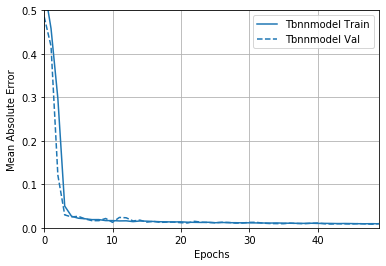

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

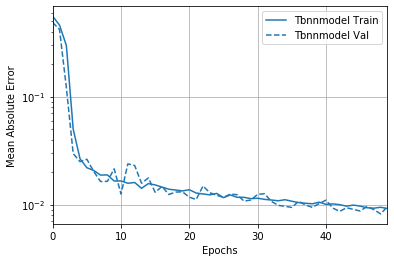

In [37]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

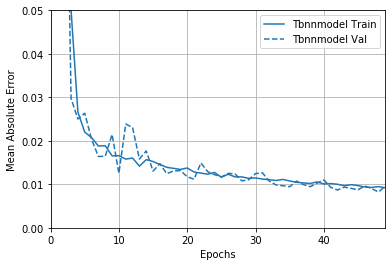

In [38]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [39]:
#!mkdir -p saved_model
#lnModel.save('lnModel.h5')
#lnModel = load_model('lnModel')

In [1]:
#def TBNNModel_optimizer(hp):
#    hp_units1 = hp.Int('units1', min_value=8, max_value=80, step=8)
#    hp_units2 = hp.Int('units2', min_value=8, max_value=80, step=8)
#    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#    hp_activation = hp.Choice('activation', values=['elu', 'relu'])
#    
#    inputs_no_tensors = keras.Input(shape=(len(train_features_no_tensors.columns),),
#                                    name='Flow_parameters_input_layer')
#    inputs_tensors = keras.Input(shape=(len(train_features_tensors.columns),),
#                                 name='Tensor_input_layer')
#    norm_no_tensors = normalizer_no_tensors(inputs_no_tensors)
#    norm_tensors = normalizer_tensors(inputs_tensors)
#    denseLayer1 = layers.Dense(units=hp_units1,
#                               activation=hp_activation,
#                               name='First_hidden_layer')(norm_no_tensors)
#    denseLayer2 = layers.Dense(units=hp_units2,
#                               activation=hp_activation,
#                               name='Second_hidden_layer')(denseLayer1)
#    concat = layers.concatenate([denseLayer2, norm_tensors],
#                            name='Parameters_concatenation')
#    outputs = layers.Dense(len(train_labels.columns), name='Last_hidden_layer')(concat)
#    TBNNModel = keras.Model(
#        inputs=[inputs_no_tensors, inputs_tensors],
#        outputs=outputs,
#    )
#    
#    TBNNModel.compile(
#        optimizer=get_optimizer(),
#        #optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#        #optimizer=keras.optimizers.Adam(learning_rate=0.001),
#        loss='mean_absolute_error',
#        metrics=[tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error')])
#    return TBNNModel

In [2]:
#tuner = kt.Hyperband(TBNNModel_optimizer,
#                     objective='val_loss',
#                     max_epochs=10,
#                     factor=3,
#                     directory='TBNNModelHpTuning',
#                     project_name='TBNNModelHpBest')

In [ ]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#%%time
#tuner.search(
#    [train_features_no_tensors, train_features_tensors],
#    train_labels,
#    epochs=50,
#    validation_split=0.2,
#    callbacks=[stop_early])

In [ ]:
# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#
#print(f"""
#The hyperparameter search is complete. The optimal number of units in the first densely-connected
#layer is {best_hps.get('units1')}, the optimal number of units in the second densely-connected
#layer is {best_hps.get('units2')}, the optimal activation function
#is {best_hps.get('activation')}.
#""")

In [ ]:
#%%time
#TBNNModelHpBest = tuner.hypermodel.build(best_hps)
#histories['TBNNModelHpBest'] = TBNNModelHpBest.fit(
#    [train_features_no_tensors, train_features_tensors],
#    train_labels,
#    epochs=50,
#    validation_split=0.2)

In [42]:
full_dnn_model_1 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [43]:
%%time
histories['full_dnn_model_1'] = compile_and_fit(
    full_dnn_model_1,
    'full_dnn_model_1',
    max_epochs=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 75)               151       
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                4864      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 5,340
Trainable params: 5,189
Non-trainable params: 151
_________________________________________________________________
Epoch 1/50
300/300 [==============================] - 39s 122ms/step - loss: 0.5247 - mean_absolute_error: 0.5247 - val_loss: 0.4529 - val_mean_absolute_error: 0.4529
Epoch 2/50
300/300 [==============================] - 29s 97ms/step - loss: 0.4223 

In [44]:
full_dnn_models['full_dnn_model_1'] = full_dnn_model_1.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [45]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819
full_dnn_model_1,0.023160,0.023160


(0.0, 0.5)

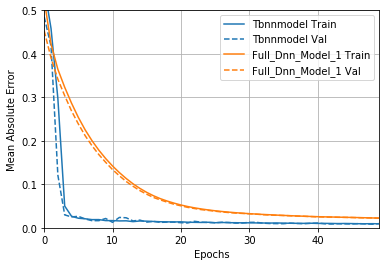

In [46]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

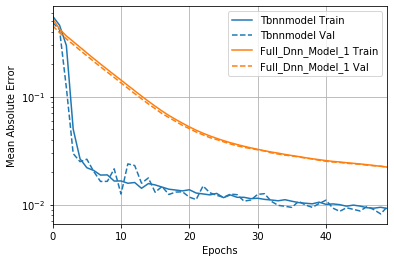

In [47]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

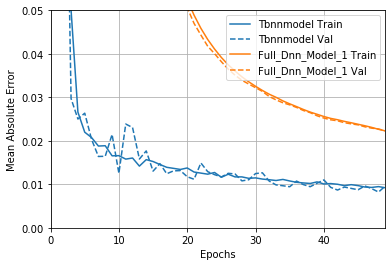

In [48]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [49]:
full_dnn_model_2 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [50]:
%%time
histories['full_dnn_model_2'] = compile_and_fit(
    full_dnn_model_2,
    'full_dnn_model_2',
    max_epochs=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 75)               151       
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4864      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 9,500
Trainable params: 9,349
Non-trainable params: 151
_________________________________________________________________
Epoch 1/50
300/300 [==============================] - 29s 94ms/step - loss: 0.4764 - mean_absolute_error: 0.4764 - v

In [51]:
full_dnn_models['full_dnn_model_2'] = full_dnn_model_2.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [52]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819
full_dnn_model_1,0.023160,0.023160
full_dnn_model_2,0.019834,0.019834


(0.0, 0.5)

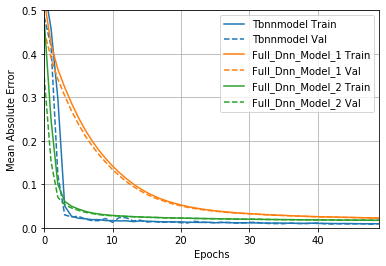

In [53]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

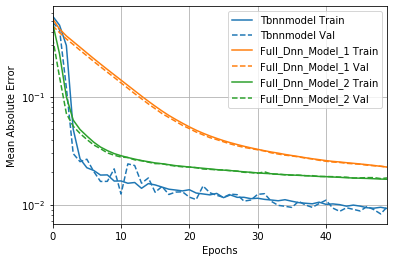

In [54]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

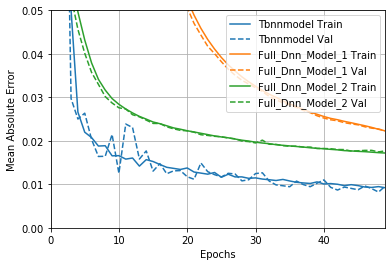

In [55]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [56]:
full_dnn_model_3 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [57]:
%%time
histories['full_dnn_model_3'] = compile_and_fit(
    full_dnn_model_3,
    'full_dnn_model_3',
    max_epochs=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 75)               151       
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                4864      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,660
Trainable params: 13,509
Non-trainable params: 151
________________________________________________

In [58]:
full_dnn_models['full_dnn_model_3'] = full_dnn_model_3.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [59]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819
full_dnn_model_1,0.023160,0.023160
full_dnn_model_2,0.019834,0.019834
full_dnn_model_3,0.019471,0.019471


(0.0, 0.5)

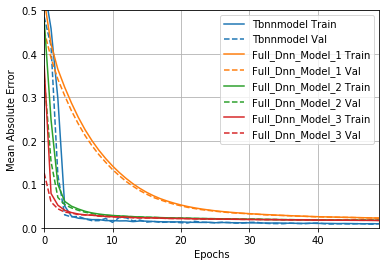

In [60]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

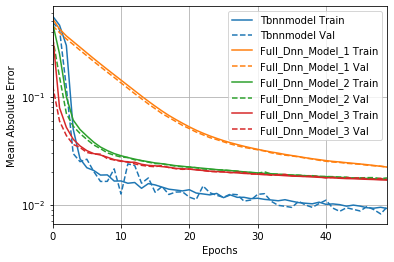

In [61]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

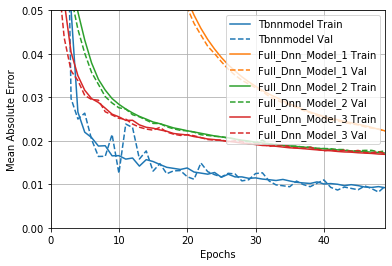

In [62]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [63]:
full_dnn_model_4 = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_LABELS)
])

In [64]:
%%time
histories['full_dnn_model_4'] = compile_and_fit(
    full_dnn_model_4,
    'full_dnn_model_4',
    max_epochs=50)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 75)               151       
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                4864      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 5)                 325       
                                                      

In [65]:
full_dnn_models['full_dnn_model_4'] = full_dnn_model_4.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [66]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819
full_dnn_model_1,0.023160,0.023160
full_dnn_model_2,0.019834,0.019834
full_dnn_model_3,0.019471,0.019471
full_dnn_model_4,0.016041,0.016041


(0.0, 0.5)

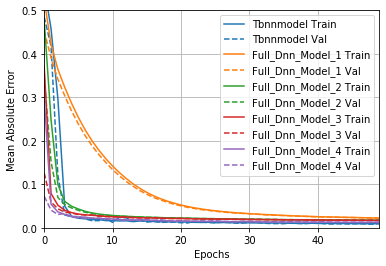

In [67]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

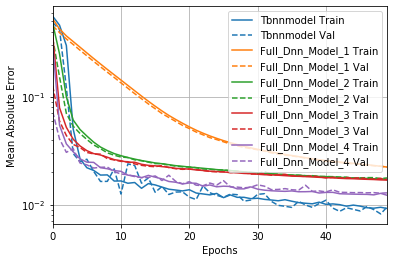

In [68]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

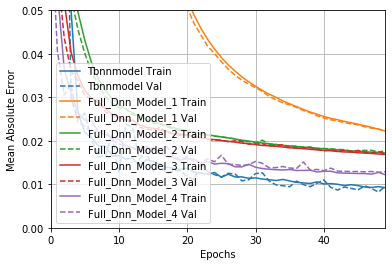

In [69]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [108]:
class LayerMultiplication(layers.Layer):
    def __init__(self, units=32):
        super(LayerMultiplication, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='w')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='b')

    def call(self, inputs):
        return tf.math.exp(tf.matmul(tf.math.log(tf.maximum(inputs, -2)+3), self.w) + self.b)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "w": self.w,
            "b": self.b,
        })
        return config

In [171]:
normalizer_UPAW = tf.keras.layers.Normalization(axis=-1, mean=mean_UPAW, variance=var_UPAW)
normalizer_SR = tf.keras.layers.Normalization(axis=-1, mean=mean_SR, variance=var_SR)
normalizer_UPAWSR = tf.keras.layers.Normalization(axis=-1, mean=mean_UPAWSR, variance=var_UPAWSR)

In [181]:
#lnModel
inputs_UPAWSR = keras.Input(shape=(len(train_features_UPAWSR.columns),))
norm_UPAWSR = normalizer_UPAWSR(inputs_UPAWSR)
multiplication = LayerMultiplication(len(train_features_UPAWSR.columns))(norm_UPAWSR)
linMembers = layers.concatenate([norm_UPAWSR, multiplication])
denseLayer1 = layers.Dense(64)(linMembers)
denseLayer2 = layers.Dense(64)(denseLayer1)
#denseLayer3 = layers.Dense(64)(denseLayer2)
outputs = layers.Dense(len(train_labels.columns))(denseLayer2)
lnModel = keras.Model(
    inputs=inputs_UPAWSR,
    outputs=outputs,
)

In [182]:
train_features_UPAWSR.columns

Index(['U0', 'U1', 'U2', 'alpha.water', 'p_rgh', 'res/U0', 'res/U1', 'res/U2',
       'res/p_rgh', 'res/alpha.water', 'res/T00', 'res/T01', 'res/T02',
       'res/T04', 'res/T05', 'res/T08', 'res/rotationRateTensor1',
       'res/rotationRateTensor2', 'res/rotationRateTensor5', 'res/gradP0',
       'res/gradP1', 'res/gradP2', 'res/gradAW0', 'res/gradAW1', 'res/gradAW2',
       'res/gradU0', 'res/gradU1', 'res/gradU2', 'res/gradU3', 'res/gradU4',
       'res/gradU5', 'res/gradU6', 'res/gradU7', 'res/gradU8'],
      dtype='object')

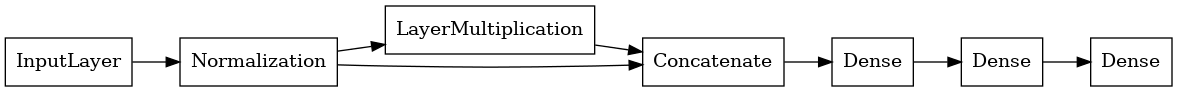

In [183]:
keras.utils.plot_model(lnModel, "multi_input_and_output_model.png", show_layer_names=False, rankdir='LR')

In [184]:
%%time
histories['lnModel'] = compile_and_fit(
    lnModel,
    'lnModel',
    train_features=train_features_UPAWSR,
    train_labels=train_labels,
    max_epochs=50)#,
    #callbacks=[cp_callback])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 normalization_16 (Normalizatio  (None, 34)          0           ['input_11[0][0]']               
 n)                                                                                               
                                                                                                  
 layer_multiplication_7 (LayerM  (None, 34)          1190        ['normalization_16[1][0]']       
 ultiplication)                                                                                   
                                                                                            

In [185]:
full_dnn_models['lnModel'] = lnModel.evaluate(
    test_features_UPAWSR,
    test_labels,
    verbose=0)

In [186]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819
full_dnn_model_1,0.023160,0.023160
full_dnn_model_2,0.019834,0.019834
full_dnn_model_3,0.019471,0.019471
full_dnn_model_4,0.016041,0.016041
lnModel,0.122685,0.122685


(0.0, 0.5)

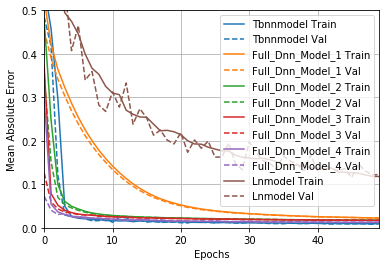

In [187]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.5])

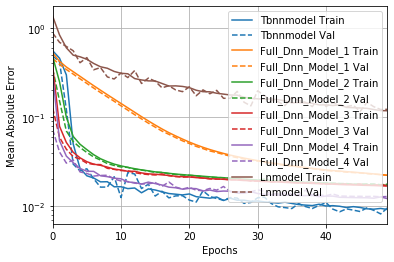

In [188]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.yscale('log')

(0.0, 0.05)

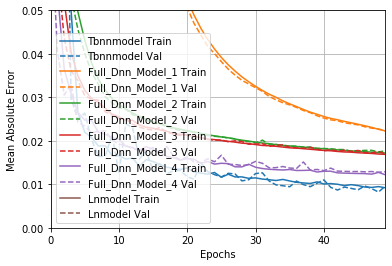

In [189]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(histories)
plt.ylim([0., 0.05])

In [70]:
pd.DataFrame(full_dnn_models).T

,0,1
TBNNModel,0.009819,0.009819
full_dnn_model_1,0.023160,0.023160
full_dnn_model_2,0.019834,0.019834
full_dnn_model_3,0.019471,0.019471
full_dnn_model_4,0.016041,0.016041


In [ ]:
#%%time
#full_dnn_model_3_prediction = pd.DataFrame(
#    data=full_dnn_model_3.predict(test_center_features),
#    columns=test_center_labels.columns)
#full_dnn_model_3_prediction

In [ ]:
#%%time
#TBNNModel_prediction = pd.DataFrame(
#    data=TBNNModel.predict(test_center_features),
#    columns=test_center_labels.columns)
#full_dnn_model_3_prediction

In [ ]:
#full_dnn_model_3_prediction_prepared = preparePrediction(full_dnn_model_3_prediction, testCenterData)
#writePrediction(full_dnn_model_3_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, MLturbRANSfolder ,'dU')
#writePrediction(full_dnn_model_3_prediction_prepared[['dp']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dp')
#writePrediction(full_dnn_model_3_prediction_prepared[['dAW']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dAW')

#TBNNModel_prediction_prepared = preparePrediction(TBNNModel_prediction, testCenterData)
#writePrediction(TBNNModel_prediction_prepared[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, MLturbRANSfolder ,'dU')
#writePrediction(TBNNModel_prediction_prepared[['dp']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dp')
#writePrediction(TBNNModel_prediction_prepared[['dAW']], 'scalar', testCenterTSL, MLturbRANSfolder ,'dAW')

#testKECenterDataPrepared = prepareInit(testKECenterData)
#writePrediction(testKECenterData[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, KEturbRANSfolder ,'dU')
#writePrediction(testKECenterData[['dp']], 'scalar', testCenterTSL, KEturbRANSfolder ,'dp')
#writePrediction(testKECenterData[['dAW']], 'scalar', testCenterTSL, KEturbRANSfolder ,'dAW')

#testKWCenterDataPrepared = prepareInit(testKWCenterData)
#writePrediction(testKWCenterData[['dU0', 'dU1', 'dU2']], 'vector', testCenterTSL, KWturbRANSfolder ,'dU')
#writePrediction(testKWCenterData[['dp']], 'scalar', testCenterTSL, KWturbRANSfolder ,'dp')
#writePrediction(testKWCenterData[['dAW']], 'scalar', testCenterTSL, KWturbRANSfolder ,'dAW')

#print(testCenterTSL)

In [3]:
#testKECenterData.describe().T

In [ ]:
#testKWCenterData.describe().T

In [ ]:
#TBNNModel_prediction_prepared.describe().T